In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import helperfunc as hf

import trainers as t
%load_ext autotime

time: 245 µs (started: 2021-02-27 19:43:13 -05:00)


In [24]:
##load data
In = np.load('data/nn_output_10.npy')
out = np.load('data/nn_input_10.npy')
N,Dx = np.shape(In)
N,Dy =np.shape(out)

print('Input shape: ', np.shape(In))
print('Output shape: ',np.shape(out))

## Normalizing
for i in range(Dx):
    if np.min(In[:,i])<-200:
        new_data = (In[:,i]-np.mean(In[:,i]))/(np.std(In[:,i]))
        In[:,i]=new_data

Input shape:  (1000000, 24)
Output shape:  (1000000, 27)
time: 513 ms (started: 2021-02-27 20:11:55 -05:00)


In [25]:
from sklearn.model_selection import train_test_split
In, X_test, out, y_test = train_test_split(In, out, test_size=0.33, random_state=42)

time: 313 ms (started: 2021-02-27 20:11:55 -05:00)


In [3]:
config_single ={
         "lr":1e-3,
         "epochs": 10,
         "batch_size": 32,
         "iters": 50,#int(N/32),
         "input_dim" : Dx,
         "output_dim" : Dy,
         "hidden1" :300,
         "hidden2" :300,
         "display_interval":30,
         "print_it" : True,
    }
NNl, critl,mselosst=t.trainsingle(config_single,In,out)

print('Single Network Loss: ',mselosst)

starting training
iter :  0 	 train loss :1.393
Single Network Loss:  0.09582410007715225
time: 3.37 s (started: 2021-02-27 19:43:14 -05:00)


In [4]:
#cor = hf.corr(In,out,Dx,Dy)
#print(np.argmin(cor))
config_section ={
        "init_select":7,
        "runs":1,
         "lr":1e-3,
         "epochs": 100,
         "batch_size": 32,
         "iters": 50,#int(N/32),
         "input_dim" : Dx,
         "output_dim" : Dy,
         "hidden1" :100,
         "hidden2" :100,
         "display_interval":30,
         "print_it" : True,
         "c":50,
         "ref_s": 7,#int(np.ceil(Dx/Dy)),
         "ref_v":np.var(In),
         "phi_1":1.0,
         "phi_2":1e-3,
         "phi_3":1e-6,
         "beta":0.5,
         "dim":0#np.argmin(cor)
    }

time: 90 ms (started: 2021-02-27 19:43:17 -05:00)


In [5]:
SN = config_section["init_select"]
iters = config_section["runs"]
dim = config_section["dim"]

l=np.zeros((iters,4))

sns=np.zeros(iters)
on,bn = hf.init_s(SN,dim,In)
dmse = np.zeros(iters)
ds = np.zeros(iters)
dv = np.zeros(iters)

mse_best=10000
best_config={}

for i in range(iters):
    NN, crit,all_in,all_out,lossind = t.trainsect(config_section, In, out,SN,on,bn)

    l[i,:]=hf.loss_1(all_in,all_out,SN,bn,on,config_section,NN,lossind,mselosst)
    
    bold,bnew,dmse[i],dv[i],ds[i] =hf.update_b(In,all_in,all_out,bn,on,SN,NN,config_section,lossind,mselosst,thresh=0.2)
    
    SN1,bn,on =hf.gen_s_b_o(bold,bnew,on,config_section,In)
    if mse_best >=np.mean(lossind):
        mse_best=np.mean(lossind)
        best_config['NN']=NN
        best_config['o']=on
        best_config['b']=bn
        best_config['sn']=SN
        best_config['crit']=crit
        best_config['all_in']=all_in
        best_config['all_out']=all_out
    print('Sn: ',SN,' bnew: ',bn, 'bold: ',bold, '\n \t LOSS2: ',np.mean(lossind),'\n mse:',l[i,1],'varloss:',l[i,2],'sloss:',l[i,3])
    sns[i]=SN
    SN=SN1
    

sorting data for section:  0


/home/labstation/Downloads/DivNet/helperfunc.py:6: RuntimeWarning: overflow encountered in exp
  return 1/(1+ np.exp(slope*(data-(offset+band))))


starting training for section:  0
iter :  0 	 train loss :5.925
iter :  30 	 train loss :0.017
iter :  60 	 train loss :0.013
iter :  90 	 train loss :0.009
data points for section:0 are:  1945
sorting data for section:  1
starting training for section:  1
iter :  0 	 train loss :3.618
iter :  30 	 train loss :0.015
iter :  60 	 train loss :0.016
iter :  90 	 train loss :0.008
data points for section:1 are:  4923
sorting data for section:  2
starting training for section:  2
iter :  0 	 train loss :1.348
iter :  30 	 train loss :0.013
iter :  60 	 train loss :0.013
iter :  90 	 train loss :0.008
data points for section:2 are:  33457
sorting data for section:  3
starting training for section:  3
iter :  0 	 train loss :0.891
iter :  30 	 train loss :0.029
iter :  60 	 train loss :0.022
iter :  90 	 train loss :0.008
data points for section:3 are:  941628
sorting data for section:  4
starting training for section:  4
iter :  0 	 train loss :3.152
iter :  30 	 train loss :0.014
iter :  60

/home/labstation/Downloads/DivNet/helperfunc.py:9: RuntimeWarning: overflow encountered in exp
  return 1/(1+ np.exp(slope*(-data+offset)))


starting training for section:  5
iter :  0 	 train loss :8.468
iter :  30 	 train loss :0.020
iter :  60 	 train loss :0.013
iter :  90 	 train loss :0.010
data points for section:5 are:  2200
sorting data for section:  6
starting training for section:  6
iter :  0 	 train loss :9.026
iter :  30 	 train loss :0.019
iter :  60 	 train loss :0.018
iter :  90 	 train loss :0.012
data points for section:6 are:  538
Sn:  7  bnew:  [3.09782326 3.12898569 3.15464971 3.15558809 3.18860636 3.22798499
 3.2022405  0.21367063] bold:  [3.19564989 3.19564989 3.19564989 3.19564989 3.19564989 3.19564989
 3.19564989] 
 	 LOSS2:  0.015269901337368148 
 mse: 0.0015807441834892553 varloss: 620.5507346851158 sloss: 0.0
time: 2min 4s (started: 2021-02-27 19:43:17 -05:00)


In [6]:
print('dmse',dmse)
print('dv',dv)
print('ds',ds)

dmse [-0.68523112]
dv [-0.01318053]
ds [-0.]
time: 1.04 ms (started: 2021-02-27 19:45:22 -05:00)


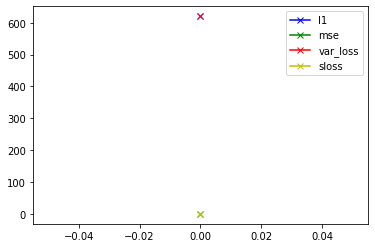

time: 148 ms (started: 2021-02-27 19:46:33 -05:00)


In [9]:
#### saving best model and plotting progress

plt.plot(l[:,0],'b-x')
plt.plot(l[:,1],'g-x')
plt.plot(l[:,2],'r-x')
plt.plot(l[:,3],'y-x')
plt.legend(['l1', 'mse', 'var_loss','sloss'])


NN=best_config['NN']
on=best_config['o']
bn=best_config['b']
SN=best_config['sn']
crit=best_config['crit']
all_in=best_config['all_in']
all_out=best_config['all_out']

In [10]:
config_tiny ={
        "input_dim":1,
        "output_dim":1,
        "hidden1":2,
        "hidden2":2,
        "lr":1e-3,
        "epochs": 200,
        "batch_size": 500,
        "iters": 100,#int(N/500),
        "display_interval":10,
        "print_it":True,
        "dim":config_section["dim"]
}
dim = config_tiny["dim"]
data,labels= hf.generate_rdata(SN,on,bn,In,dim)
NNt, criteriont,loss=t.traintiny(config_tiny, data,labels)


starting training
iter :  0 	 train loss :0.902
iter :  10 	 train loss :0.019
iter :  20 	 train loss :0.020
iter :  30 	 train loss :0.017
iter :  40 	 train loss :0.015
iter :  50 	 train loss :0.021
iter :  60 	 train loss :0.018
iter :  70 	 train loss :0.016
iter :  80 	 train loss :0.020
iter :  90 	 train loss :0.017
iter :  100 	 train loss :0.020
iter :  110 	 train loss :0.019
iter :  120 	 train loss :0.021
iter :  130 	 train loss :0.021
iter :  140 	 train loss :0.078
iter :  150 	 train loss :0.020
iter :  160 	 train loss :0.021
iter :  170 	 train loss :0.016
iter :  180 	 train loss :0.021
iter :  190 	 train loss :0.017
iter :  200 	 train loss :0.086
iter :  210 	 train loss :0.020
iter :  220 	 train loss :0.017
iter :  230 	 train loss :0.019
iter :  240 	 train loss :0.020
iter :  250 	 train loss :0.019
iter :  260 	 train loss :0.017
iter :  270 	 train loss :0.019
iter :  280 	 train loss :0.016
iter :  290 	 train loss :0.022
iter :  300 	 train loss :0.016
i

NameError: name 'torch' is not defined

time: 16min 59s (started: 2021-02-27 19:46:38 -05:00)


In [11]:
import torch
NNt.eval()
X_train = torch.tensor(data, dtype=torch.float) #  tensor
outputs = NNt(X_train)
outs=np.round(outputs.detach().numpy())
tot=np.abs(outs-labels)
tot= np.sum(tot)
print('Incorrect labels', tot)

Incorrect labels 11900.0
time: 35.4 ms (started: 2021-02-27 20:04:29 -05:00)


In [47]:
import torch.nn as nn
def test(NNt,NN,X_test, y_test,SN,dim,on,bn):
    criterion = nn.MSELoss()
    NNt.eval()
    N,D = np.shape(X_test)
    data =np.reshape(X_test[:,dim],(N,1))
    data = torch.tensor(data, dtype=torch.float)
    X_test = torch.tensor(X_test, dtype=torch.float,requires_grad=True)
    y_test = torch.tensor(y_test, dtype=torch.float) #  tensor
    selectors = NNt(data).detach().numpy()
    loss = 0 
    print('calculating loss')
    for i in range(N):
        j = int(selectors[i])
        NN[str(j)].eval()
        ypred=NN[str(j)](X_test[i])
        loss += criterion(ypred, y_test[i]).item()
        #ypred[i]=NN[str(j)](torch.tensor(X_test[i], dtype=torch.float)).detach().numpy()
    #ypred = torch.tensor(ypred, dtype=torch.float) #  tensor
    
    return loss/N

time: 2.29 ms (started: 2021-02-27 20:34:01 -05:00)


In [48]:
Nt,Dt = np.shape(X_test)

time: 899 µs (started: 2021-02-27 20:34:01 -05:00)


In [49]:
dim = config_tiny["dim"]

loss = test(NNt,NN,X_test,y_test,SN,dim,on,bn)
print('test loss =', loss)

calculating loss
test loss = 0.4722428111512004
time: 1min 14s (started: 2021-02-27 20:34:02 -05:00)


In [51]:
print('time per data point:',74000/Nt)

time per data point: 0.22424242424242424
time: 1.08 ms (started: 2021-02-27 20:35:57 -05:00)


In [52]:
dim = config_tiny["dim"]
loss = test(NNt,NN,In,out,SN,dim,on,bn)
print('train loss =', loss)

calculating loss
train loss = 0.4800921927823426
time: 2min 36s (started: 2021-02-27 20:36:04 -05:00)


In [53]:
Nt,Dt = np.shape(In)

print('time per data point:',156000/Nt)

time per data point: 0.23283582089552238
time: 1.28 ms (started: 2021-02-27 20:39:00 -05:00)


In [54]:
import torch.nn as nn
def testl(NNl,X_test, y_test):
    criterion = nn.MSELoss()
    N,D = np.shape(X_test)

    X_test = torch.tensor(X_test, dtype=torch.float,requires_grad=True)
    y_test = torch.tensor(y_test, dtype=torch.float) #  tensor
    loss = 0 
    print('calculating loss')
    NNl.eval
    for i in range(N):
        NNl.eval()
        ypred=NNl(X_test[i])
        loss += criterion(ypred, y_test[i]).item()
        #ypred[i]=NN[str(j)](torch.tensor(X_test[i], dtype=torch.float)).detach().numpy()
    #ypred = torch.tensor(ypred, dtype=torch.float) #  tensor
    
    return loss/N

time: 3.41 ms (started: 2021-02-27 20:41:32 -05:00)


In [55]:
dim = config_tiny["dim"]

loss = testl(NNl,X_test,y_test)
print('test loss =', loss)

calculating loss
test loss = 0.09665124761041811
time: 1min 19s (started: 2021-02-27 20:41:33 -05:00)


In [56]:
Nt,Dt = np.shape(X_test)

print('time per data point:',79000/Nt)

time per data point: 0.23939393939393938
time: 1.49 ms (started: 2021-02-27 20:43:11 -05:00)


In [57]:
dim = config_tiny["dim"]
loss = testl(NNl,In,out)
print('train loss =', loss)

calculating loss
train loss = 0.09541669687693644
time: 2min 35s (started: 2021-02-27 20:43:24 -05:00)


In [58]:
Nt,Dt = np.shape(In)

print('time per data point:',155000/Nt)

time per data point: 0.23134328358208955
time: 6.84 ms (started: 2021-02-27 20:46:46 -05:00)
